In [1]:
# Cell 1 — Notebook title & imports
# Run this cell first.

# Title
print("Spotify Recommendation Notebook — ready to run (5000 rows)")

# Imports
import pandas as pd
import numpy as np
!pip install pandas==2.2.2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
import shap
from IPython.display import display, HTML
%matplotlib inline

# Make plots look nicer
sns.set(style='whitegrid')

Spotify Recommendation Notebook — ready to run (5000 rows)


C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
print(pd.__version__)

2.2.2


# DATA LOADING AND PRE PROCESSING

In [4]:
# Cell 2 — Load & preprocess data (5000 rows)
# Put your spotify.csv file in the same folder as the notebook.

def load_data(nrows=5000):
    df = pd.read_csv("spotify.csv")
    # drop rows with any missing values (same as your app)
    df = df.dropna()
    # take first nrows for speed
    df = df.head(nrows)
    # ensure explicit is numeric
    if 'explicit' in df.columns:
        if df['explicit'].dtype not in ['int64', 'float64']:
            try:
                df['explicit'] = df['explicit'].astype(int)
            except:
                df['explicit'] = df['explicit'].replace({True:1, False:0}).astype(int)
    # build text features for TF-IDF
    df['text_features'] = (
        df['artists'].astype(str) + ' ' + df['album_name'].astype(str) + ' ' +
        df['track_name'].astype(str) + ' ' + df['track_genre'].astype(str) + ' ' +
        df['danceability'].astype(str) + ' ' + df['energy'].astype(str) + ' ' +
        df['loudness'].astype(str) + ' ' + df['popularity'].astype(str) + ' ' +
        df['duration_ms'].astype(str) + ' ' + df['valence'].astype(str)
    )
    return df

# Load dataset (5000 rows)
df = load_data(5000)
print("Loaded rows:", len(df))
df.head()

Loaded rows: 5000


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,text_features
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,Gen Hoshino Comedy Comedy acoustic 0.676 0.461...
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,Ben Woodward Ghost (Acoustic) Ghost - Acoustic...
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,Ingrid Michaelson;ZAYN To Begin Again To Begin...
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,Kina Grannis Crazy Rich Asians (Original Motio...
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,Chord Overstreet Hold On Hold On acoustic 0.61...


In [5]:
df.isna().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
text_features       0
dtype: int64

In [6]:
df.info

<bound method DataFrame.info of       Unnamed: 0                track_id                 artists  \
0              0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1              1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2              2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3              3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4              4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...          ...                     ...                     ...   
4995        4995  5i4zyaQRXAX9oI2C9dmHdB        Ludovico Einaudi   
4996        4996  5tR13oIwi5J3elcTZPTTIU                     Air   
4997        4997  76R8ILULQyyodS91TkAvOf        Ludovico Einaudi   
4998        4998  1GyODtIqjM5AO3z5dEJwRg             Liquid Mind   
4999        4999  6pEzb2WKU1YQxRIHc6k1LG             Liquid Mind   

                                             album_name  \
0                                                Comedy   
1                                

In [7]:
print(df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'text_features'],
      dtype='object')


In [8]:
df.describe()

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,33.870600,2.315682e+05,0.059000,0.536292,0.569909,5.369200,-9.621765,0.638800,0.059312,0.376890,0.212059,0.175750,0.460794,119.240778,3.873000
std,1443.520003,24.906391,7.955663e+04,0.235648,0.169558,0.282980,3.558008,6.406929,0.480396,0.055272,0.368513,0.353766,0.151826,0.270292,29.983317,0.471291
min,0.000000,0.000000,3.182400e+04,0.000000,0.000000,0.001440,0.000000,-41.808000,0.000000,0.000000,0.000002,0.000000,0.014400,0.000000,0.000000,0.000000
25%,1249.750000,9.000000,1.859060e+05,0.000000,0.428000,0.334000,2.000000,-11.107250,0.000000,0.033100,0.025800,0.000000,0.094300,0.227000,96.599750,4.000000
50%,2499.500000,35.000000,2.222260e+05,0.000000,0.548000,0.619000,5.000000,-7.564500,1.000000,0.041200,0.237500,0.000320,0.116000,0.437000,118.021000,4.000000
75%,3749.250000,54.000000,2.616400e+05,0.000000,0.663000,0.818000,9.000000,-5.568000,1.000000,0.060325,0.772000,0.305250,0.203000,0.689000,139.717250,4.000000
max,4999.000000,93.000000,1.041520e+06,1.000000,0.974000,0.997000,11.000000,-0.223000,1.000000,0.924000,0.996000,0.986000,0.992000,0.995000,220.081000,5.000000


In [9]:
df.shape

(5000, 22)

# MODEL BUILDING (TF-IDF,KMeans,Mood)

In [10]:
# Cell 3 — Build models: TF-IDF + Cosine similarity, KMeans, mood
# This cell does the heavy lifting.

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Numeric features + scaling for clustering & SHAP
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
features = df[numeric_cols].fillna(0)
normalized = scaler.fit_transform(features)

# KMeans
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(normalized)

# Mood
def categorize_mood(valence):
    if valence > 0.7:
        return 'Positive'
    elif valence >= 0.4:
        return 'Neutral'
    else:
        return 'Negative'

df['mood'] = df['valence'].apply(categorize_mood)

print("Models ready: TF-IDF matrix shape:", tfidf_matrix.shape)
print("Numeric columns used for clustering:", numeric_cols)

Models ready: TF-IDF matrix shape: (5000, 5000)
Numeric columns used for clustering: ['Unnamed: 0', 'popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [11]:
# Cell 4 — Recommendation and helper functions (core logic)
from typing import Optional

class SpotifyRecommendation:
    def __init__(self, dataset: pd.DataFrame, cosine_sim_matrix: np.ndarray):
        self.dataset = dataset
        self.cosine_sim = cosine_sim_matrix

    def recommend(self, song_name: str, amount: int = 5) -> Optional[pd.DataFrame]:
        indices = self.dataset.index[self.dataset['track_name'].str.lower() == song_name.lower()].tolist()
        if not indices:
            return None
        idx = indices[0]
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:amount+1]
        track_indices = [i[0] for i in sim_scores]
        return self.dataset[['artists', 'track_name']].iloc[track_indices].reset_index(drop=True)

def get_cluster_recommendations(track_name: str, df_subset: pd.DataFrame, amount: int = 5) -> Optional[pd.DataFrame]:
    matches = df_subset[df_subset['track_name'].str.lower() == track_name.lower()]
    if matches.empty:
        return None
    track_cluster = int(matches['cluster'].iloc[0])
    cluster_df = df_subset[df_subset['cluster'] == track_cluster]
    if cluster_df.empty:
        return None
    return cluster_df[['artists', 'track_name']].sample(min(amount, len(cluster_df))).reset_index(drop=True)

## CONTENT BASED RECOMMENDATION

In [12]:
# Cell 5 — TQDM-enabled user-facing recommendation wrappers with AI-style explanations
import time

def recommend_content(song: str, num: int = 5):
    print(f"Finding top {num} content-based recommendations for: {song}")
    for _ in tqdm(range(40), desc="Processing", ncols=70):
        time.sleep(0.01)  # small visual delay
    engine = SpotifyRecommendation(df, cosine_sim)
    results = engine.recommend(song, amount=num)
    if results is None or results.empty:
        print("Song not found in dataset. Try exact track name from your CSV.")
        return
    display(results)
    print("\n🤖 Why these songs were recommended:")
    print(f"Based on TF-IDF and cosine similarity, these tracks are textually and acoustically similar to '{song}'.")
    print("The algorithm considers features like artist/album/genre names plus numeric audio-features embedded in the text (danceability, energy, valence, loudness, etc.).")
    # Content-based example
recommend_content("Hold On", num=5)

Finding top 5 content-based recommendations for: Hold On


Processing: 100%|█████████████████████| 40/40 [00:00<00:00, 56.49it/s]


,artists,track_name
0,Chord Overstreet,Hold On
1,Chord Overstreet,Hold On - Acoustic
2,Chord Overstreet;Deepend,Hold On - Remix
3,Christian Löffler,Versailles (Hold) - Edit
4,JJ Heller,Hand to Hold



🤖 Why these songs were recommended:
Based on TF-IDF and cosine similarity, these tracks are textually and acoustically similar to 'Hold On'.
The algorithm considers features like artist/album/genre names plus numeric audio-features embedded in the text (danceability, energy, valence, loudness, etc.).


## CLUSTER-BASED RECOMMENDATION

In [13]:
def recommend_cluster(song: str, num: int = 5):
    print(f"Finding top {num} cluster-based recommendations for: {song}")
    for _ in tqdm(range(40), desc="Processing", ncols=70):
        time.sleep(0.01)
    results = get_cluster_recommendations(song, df, amount=num)
    if results is None or results.empty:
        print("Song not found in dataset or no cluster matches.")
        return
    display(results)
    print("\n🤖 Why these songs were recommended:")
    print(f"'{song}' belongs to a cluster built from numeric audio features (energy, valence, danceability, tempo, loudness, etc.).")
    print("Recommended tracks are sampled from the same cluster and share similar acoustic profiles.")
# Cluster-based example
recommend_cluster("Hold On", num=5)

Finding top 5 cluster-based recommendations for: Hold On


Processing: 100%|█████████████████████| 40/40 [00:00<00:00, 56.41it/s]


,artists,track_name
0,Ciaran Lavery,Left for America
1,Aron Wright,You & Me (The Wildfire)
2,Sara Farell,Sunflower
3,Kina Grannis,Oh What A Love
4,Novo Amor;Ed Tullett;Lowswimmer,Ontario



🤖 Why these songs were recommended:
'Hold On' belongs to a cluster built from numeric audio features (energy, valence, danceability, tempo, loudness, etc.).
Recommended tracks are sampled from the same cluster and share similar acoustic profiles.


## MOOD BASED RECOMMENDATION

In [14]:
def recommend_mood(mood: str, num: int = 5):
    print(f"Finding top {num} tracks with mood: {mood}")
    for _ in tqdm(range(40), desc="Processing", ncols=70):
        time.sleep(0.01)
    sample = df[df['mood'] == mood]
    if sample.empty:
        print("No songs found for this mood.")
        return
    sample = sample.sample(min(num, len(sample)))
    display(sample[['artists', 'track_name', 'valence']].reset_index(drop=True))
    print("\n🤖 Why these songs were recommended:")
    print(f"These fall into the '{mood}' category determined by valence (positivity).")
    print("Valence thresholds: >0.7 Positive, 0.4–0.7 Neutral, <0.4 Negative.")
# Mood-based example
recommend_mood("Positive", num=5)

Finding top 5 tracks with mood: Positive


Processing: 100%|█████████████████████| 40/40 [00:00<00:00, 56.12it/s]


,artists,track_name,valence
0,Counting Crows;Vanessa Carlton,Big Yellow Taxi,0.821
1,Los Amigos Invisibles,Sueño Erótico,0.837
2,The Souljazz Orchestra,Is yeelyel,0.914
3,The 1975,Part Of The Band,0.832
4,Juanafé,El Que Te Quiere Te Quiere,0.783



🤖 Why these songs were recommended:
These fall into the 'Positive' category determined by valence (positivity).
Valence thresholds: >0.7 Positive, 0.4–0.7 Neutral, <0.4 Negative.


## DURATION & ENERGY BASED RECOMMENDATION

In [15]:
def recommend_duration_energy(dur_range: tuple, energy_range: tuple, num: int = 5):
    print(f"Filtering for duration between {dur_range} ms and energy between {energy_range}")
    for _ in tqdm(range(40), desc="Processing", ncols=70):
        time.sleep(0.01)
    filtered = df[(df['duration_ms'].between(*dur_range)) & (df['energy'].between(*energy_range))]
    if filtered.empty:
        print("No matches found for those ranges.")
        return
    sample = filtered.sample(min(num, len(filtered)))
    display(sample[['artists', 'track_name', 'duration_ms', 'energy']].reset_index(drop=True))
    print("\n🤖 Why these songs were recommended:")
    print("These tracks matched the duration and energy thresholds you selected. Duration controls song length profile (short/long), energy reflects tempo/loudness/activity.")
# Duration & energy example (150k-300k ms, energy 0.6-1.0)
recommend_duration_energy((150000, 300000), (0.6, 1.0), num=5)

Filtering for duration between (150000, 300000) ms and energy between (0.6, 1.0)


Processing: 100%|█████████████████████| 40/40 [00:00<00:00, 59.91it/s]


,artists,track_name,duration_ms,energy
0,Lucybell,Sembrando En El Mar,231026,0.847
1,Calle 13,La Crema,241240,0.748
2,The Score,Who I Am,215746,0.689
3,Andrés Calamaro;Juanes;Niño Josele,Enganchate Conmigo,225616,0.646
4,Patricio Rey y sus Redonditos de Ricota,Ella Baila Con Todos,299160,0.797



🤖 Why these songs were recommended:
These tracks matched the duration and energy thresholds you selected. Duration controls song length profile (short/long), energy reflects tempo/loudness/activity.


# VISUALIZATIONS

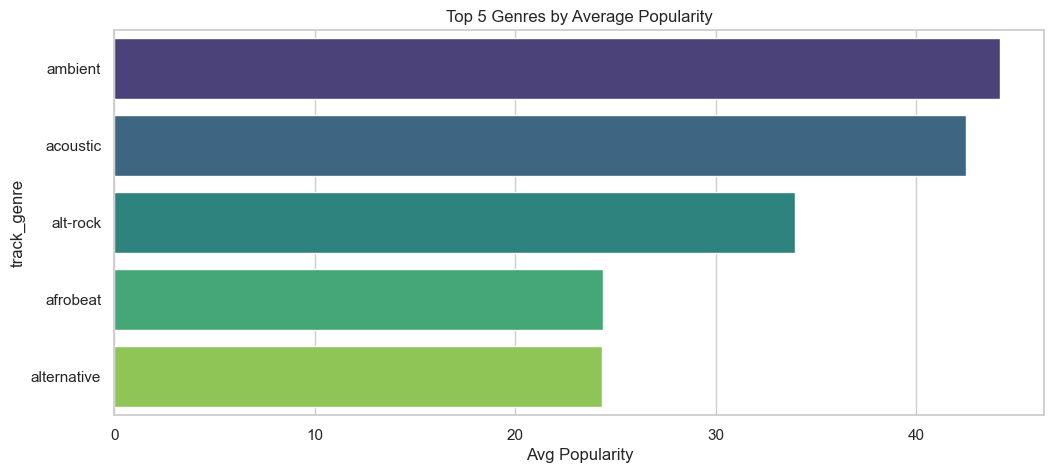

In [16]:
# Cell 6 — Visualizations (functions)
def plot_genre_popularity(top_n=20):
    genre_pop = df.groupby("track_genre")["popularity"].mean().sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(12,5))
    sns.barplot(x=genre_pop.values, y=genre_pop.index, palette="viridis")
    plt.xlabel("Avg Popularity")
    plt.title("Top 5 Genres by Average Popularity")
    plt.show()
plot_genre_popularity(top_n=15)    

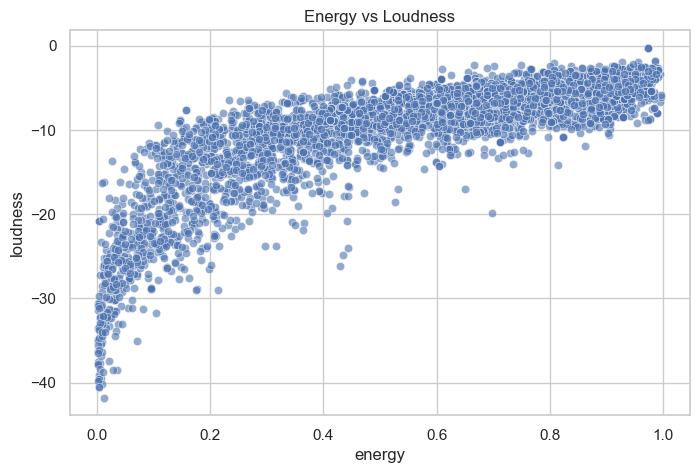

In [17]:
def plot_energy_vs_loudness():
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x='energy', y='loudness', alpha=0.6)
    plt.title("Energy vs Loudness")
    plt.show()
plot_energy_vs_loudness()    

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


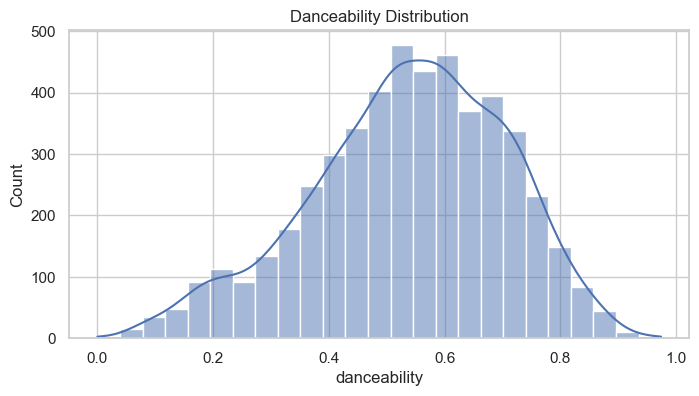

In [18]:
def plot_danceability_dist():
    plt.figure(figsize=(8,4))
    sns.histplot(df["danceability"], bins=25, kde=True)
    plt.title("Danceability Distribution")
    plt.show()
plot_danceability_dist()    

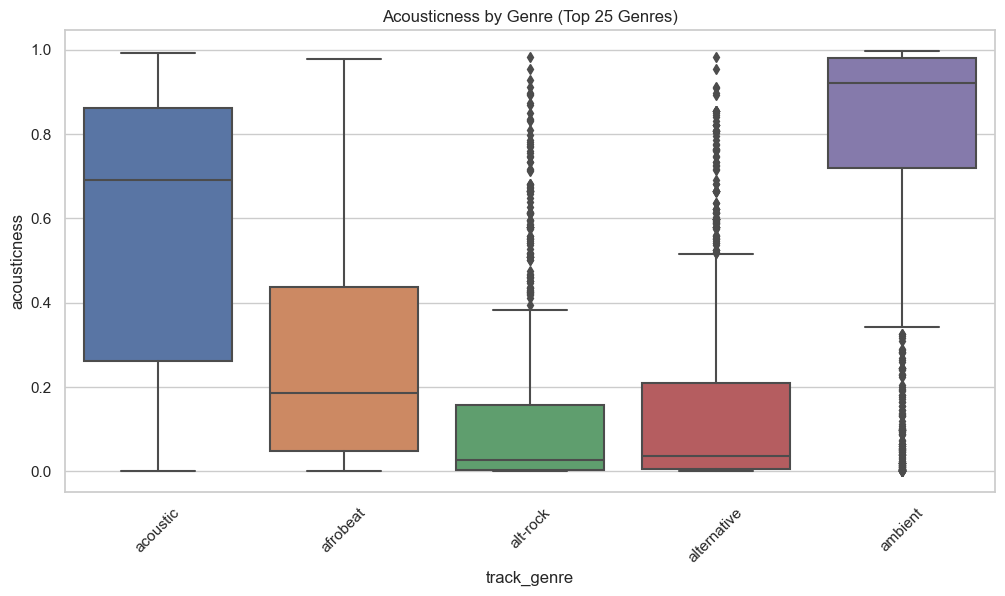

In [19]:
def plot_acousticness_by_genre(top_n=25):
    top_genres = df['track_genre'].value_counts().nlargest(top_n).index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='track_genre', y='acousticness', data=df[df['track_genre'].isin(top_genres)])
    plt.xticks(rotation=45)
    plt.title("Acousticness by Genre (Top 25 Genres)")
    plt.show()
plot_acousticness_by_genre(top_n=12)    

# WORD CLOUD

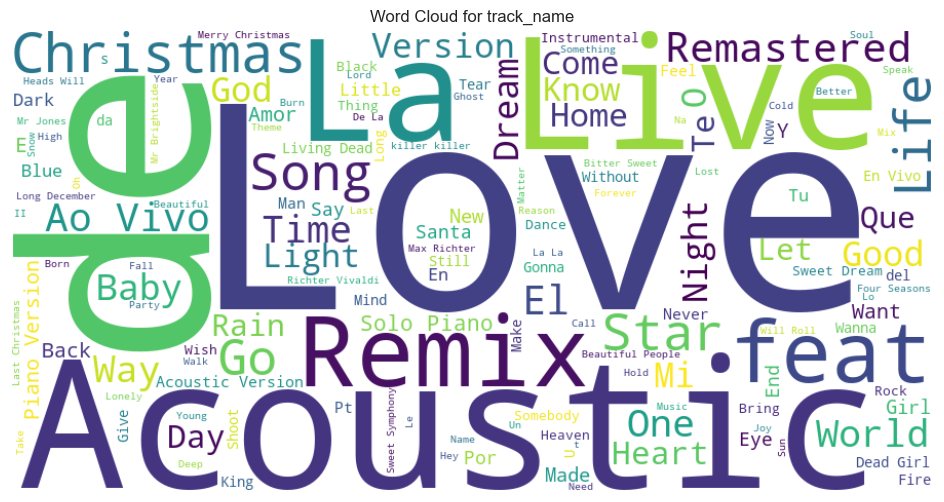

In [20]:
# Cell 7 — Word Cloud generator
def generate_wordcloud(column='track_name', max_words=200):
    text = " ".join(df[column].dropna().astype(str).tolist())
    if not text.strip():
        print("No text data in column:", column)
        return
    wc = WordCloud(width=900, height=450, max_words=max_words, background_color='white').generate(text)
    plt.figure(figsize=(14,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column}")
    plt.show()
 # Word cloud
generate_wordcloud("track_name", max_words=150)   

# SHAP Explainability

Song assigned to cluster: 7


  0%|          | 0/1 [00:00<?, ?it/s]

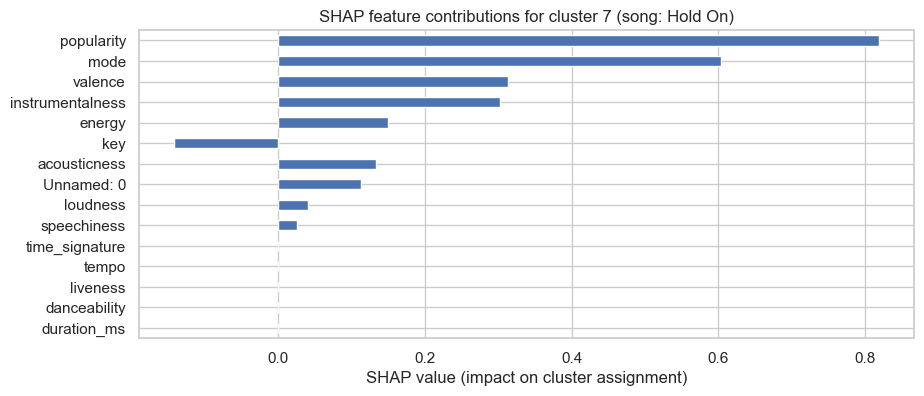

,value
Unnamed: 0,4
popularity,82
duration_ms,198853
danceability,0.618
energy,0.443
key,2
loudness,-9.681
mode,1
speechiness,0.0526
acousticness,0.469


In [21]:
# Cell 8 — SHAP Explainability for a single song's cluster (fast)
def explain_cluster_with_shap(song: str, background_size: int = 50):
    indices = df.index[df['track_name'].str.lower() == song.lower()].tolist()
    if not indices:
        print("Song not found.")
        return
    idx = indices[0]
    # background sample (normalized) for KernelExplainer
    background_size = min(background_size, normalized.shape[0])
    background = shap.sample(normalized, background_size, random_state=42)
    vector = normalized[idx].reshape(1, -1)
    cluster_assigned = int(kmeans.predict(vector)[0])
    print(f"Song assigned to cluster: {cluster_assigned}")
    with np.errstate(all='ignore'):
        explainer = shap.KernelExplainer(kmeans.predict, background)
        shap_values = explainer.shap_values(vector)
    try:
        contrib = np.array(shap_values)[cluster_assigned][0]
    except Exception:
        contrib = np.array(shap_values)[0]
    contrib_series = pd.Series(contrib, index=numeric_cols).sort_values(key=lambda s: np.abs(s), ascending=True)
    plt.figure(figsize=(10, max(4, 0.25*len(numeric_cols))))
    contrib_series.plot(kind='barh')
    plt.title(f"SHAP feature contributions for cluster {cluster_assigned} (song: {song})")
    plt.xlabel("SHAP value (impact on cluster assignment)")
    plt.show()
    # show numeric feature values for the song
    display(df.loc[idx, numeric_cols].to_frame(name='value'))
# SHAP explainability (single song)
explain_cluster_with_shap("Hold On", background_size=50)    

# MODEL EVALUATION

Average Precision@5: 0.49
Average Recall@5: 0.66
Coverage: 4.53%


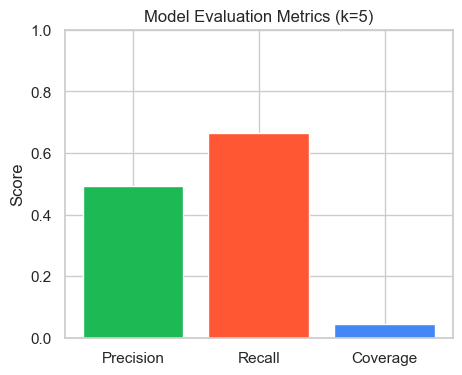

In [22]:
import matplotlib.pyplot as plt

def evaluate_recommender(k=5, sample_size=50):
    total_precision, total_recall, unique_recs = 0, 0, set()
    count = 0

    for song in df['track_name'].unique()[:sample_size]:
        recs = SpotifyRecommendation(df, cosine_sim).recommend(song, amount=k)
        if recs is None or recs.empty:
            continue

        input_artist = df.loc[df['track_name'].str.lower() == song.lower(), 'artists'].iloc[0]
        relevant = df[df['artists'] == input_artist]['track_name'].nunique() - 1
        hits = recs[recs['artists'] == input_artist]

        precision = len(hits) / k
        recall = len(hits) / max(1, relevant)

        total_precision += precision
        total_recall += recall
        unique_recs.update(recs['track_name'].tolist())
        count += 1

    avg_precision = total_precision/count
    avg_recall = total_recall/count
    coverage = len(unique_recs)/df['track_name'].nunique()

    # Print metrics
    print(f"Average Precision@{k}: {avg_precision:.2f}")
    print(f"Average Recall@{k}: {avg_recall:.2f}")
    print(f"Coverage: {coverage:.2%}")

    # Plot metrics
    metrics = ['Precision', 'Recall', 'Coverage']
    values = [avg_precision, avg_recall, coverage]
    plt.figure(figsize=(5,4))
    plt.bar(metrics, values, color=['#1DB954', '#FF5733', '#4287f5'])
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title(f"Model Evaluation Metrics (k={k})")
    plt.show()

# Run evaluation
evaluate_recommender(k=5, sample_size=50)


In [26]:
import os
os.chdir(r"C:\Users\hp\OneDrive\Desktop\ff")
print("Current wd :",os.getcwd())# This shows your current working directory


Current wd : C:\Users\hp\OneDrive\Desktop\ff


In [23]:
import pickle

with open("model3.pkl", "wb") as f:
    pickle.dump({
        "df": df,
        "cosine_sim": cosine_sim,
        "tfidf_vectorizer": tfidf_vectorizer,
        "kmeans": kmeans,
        "scaler": scaler,
        "numeric_cols": numeric_cols,
        "normalized": normalized
    }, f)
    
print("created")    


created


In [27]:
import os
print(os.getcwd())

C:\Users\hp\OneDrive\Desktop\ff
